In [1]:
import os
import sys
from pathlib import Path
import pathlib
import tensorflow as tf
import matplotlib.patches as patches
import cv2
import time

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from object_detection.utils import label_map_util


sys.path.append('../utils')

from find_vehicle_locations import find_detections_and_centroid_in_image, get_model

In [2]:
test_image_locations='../workspace/gta_project/test'

MODEL_NAME ='three_class_resnet50_v1_fpn_120821'

In [3]:
PATH_TO_MODEL_DIR = f'../workspace/gta_project/exported-models/{MODEL_NAME}'
PATH_TO_LABELS = f'../workspace/gta_project/exported-models/{MODEL_NAME}/label_map.pbtxt'

model_descript = MODEL_NAME

saveImage = False

In [4]:
all_image_file_paths = np.array([file_path for file_path in Path(test_image_locations).glob('**/*.jpg')])

N = len(all_image_file_paths)

print(f'There are {N} test images.')

There are 2631 test images.


In [5]:
# Load saved model and build the detection function
detect_fn = get_model(PATH_TO_MODEL_DIR)

Loading model...Done! Took 19.14826798439026 seconds


# Project Lidar into Image Plane

Class 2 74.70%
Guess UV: [909.26155094 493.99655531   1.        ]
Actual UV: [909 497   1]


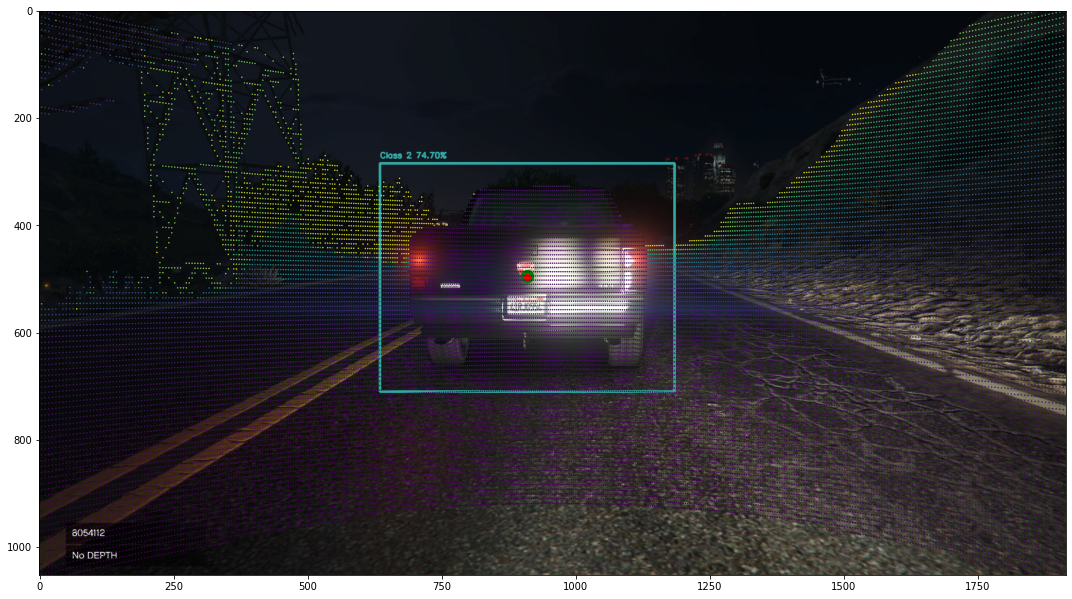

In [6]:
# Get Random Image from Test Files
i_rand = np.random.randint(N)
imageFileLocation = str(all_image_file_paths[i_rand])


xyz = np.fromfile(imageFileLocation.replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
xyz = xyz.reshape([3, -1])

proj = np.fromfile(imageFileLocation.replace('_image.jpg', '_proj.bin'), dtype=np.float32)
proj.resize([3, 4])

# Lidar Points in Pixels 
uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
uv = uv / uv[2, :]

dist = np.linalg.norm(xyz, axis=0)



image, cent_x, cent_y = find_detections_and_centroid_in_image(imageFileLocation,detect_fn,category_index=None)

centroid = np.array([cent_x, cent_y,1])

idx_centroid = np.argmin(np.linalg.norm(uv - centroid[:,None],axis=0))
lidar_centroid = xyz[:,idx_centroid]

uv_lidar_c = np.dot(proj, np.append(lidar_centroid,1))
uv_lidar_c = uv_lidar_c / uv_lidar_c[2]

print(f"Guess UV: {uv_lidar_c}")
print(f"Actual UV: {centroid}")

plt.figure(figsize=(15,10))
plt.imshow(image)

plt.scatter([uv_lidar_c[0]],[uv_lidar_c[1]],color='green',s=150)
plt.scatter([cent_x],[cent_y],color='red') 

plt.scatter(uv[0,:],uv[1,:], c=dist, marker='.', s=1) 

plt.tight_layout()

if saveImage:
    fileName = f"{Path(imageFileLocation).stem}_boxed.jpg"
    plt.savefig(fileName)


plt.show()

